# **1-  Initialization and Configuration**

In [7]:

!unzip /content/result_tokenizer_gpt2.zip -d /content/

Archive:  /content/result_tokenizer_gpt2.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/result_tokenizer_gpt2.zip or
        /content/result_tokenizer_gpt2.zip.zip, and cannot find /content/result_tokenizer_gpt2.zip.ZIP, period.


In [8]:
# Cell 1: Imports and Setup
import torch
from pathlib import Path
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import matplotlib.pyplot as plt

# Paths to our checkpoints and tokenizers
default_model = "gpt2"
custom_ckpt = "/content/checkpoint_texttokenizer"

# Load model once
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained(default_model).to(device)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [9]:
# Cell 2: Load Tokenizers
base_tok = GPT2TokenizerFast.from_pretrained(default_model)
custom_tok = GPT2TokenizerFast.from_pretrained(
    custom_ckpt,
    unk_token="<unk>", pad_token="<pad>", bos_token="<s>", eos_token="</s>"
)

print(f"Base vocab size: {len(base_tok)}")
print(f"Custom vocab size: {len(custom_tok)}")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Base vocab size: 50257
Custom vocab size: 15057


# **2- Key Insights From Our Custom Tokenizer**

# A- Corpus Overview : Sentence Lengths and Token Distribution


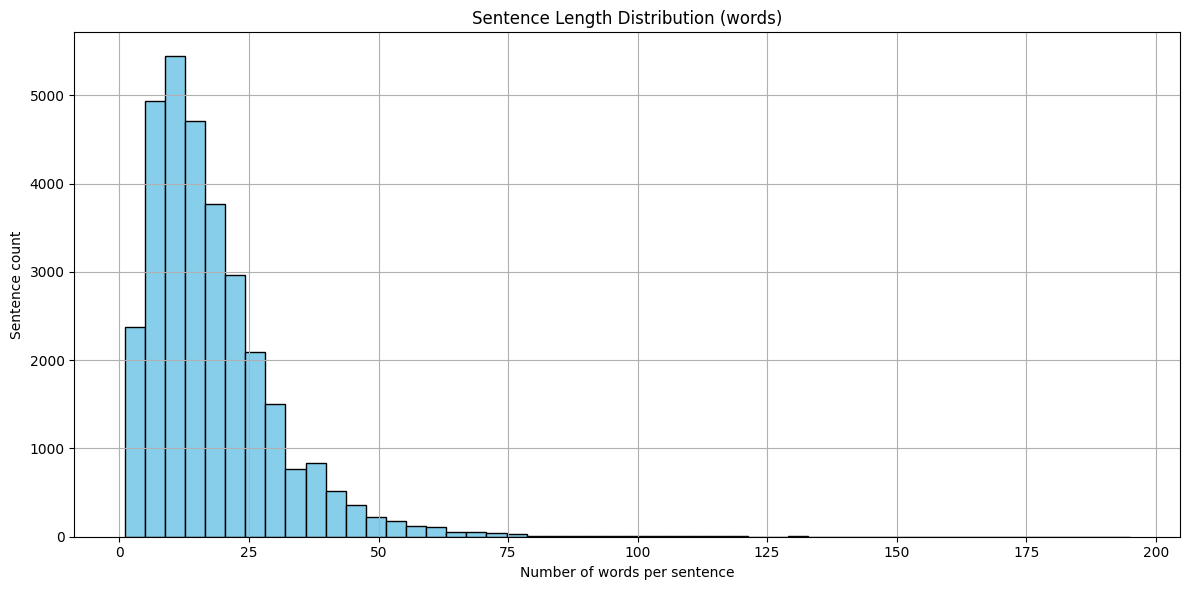

In [33]:
# Cell 3: Sentence Length & Token Frequency Analysis
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path

# 1) We Load all sentences and compute lengths in words
lines = Path("sentences.txt").read_text(encoding="utf-8").splitlines()
lengths_words = [len(line.split()) for line in lines]

# 2) We Build token frequency using our custom tokenizer
freq = Counter()
for line in lines:
    freq.update(custom_tok(line).input_ids)
top_tokens = freq.most_common(30)
tokens, counts = zip(*[(custom_tok.convert_ids_to_tokens(tid), cnt) for tid, cnt in top_tokens])

# 3) We Compute cumulative vocabulary coverage
total_count = sum(freq.values())
sorted_counts = [cnt for _, cnt in freq.most_common()]
cum_coverage = [sum(sorted_counts[:i+1]) / total_count for i in range(len(sorted_counts))]

# Create subplots for cleaner display


# Plot 1: Sentence length histogram
fig1, ax1 = plt.subplots(figsize=(12, 6))
ax1.hist(lengths_words, bins=50, color='skyblue', edgecolor='black')
ax1.set_title("Sentence Length Distribution (words)")
ax1.set_xlabel("Number of words per sentence")
ax1.set_ylabel("Sentence count")
ax1.grid(True)
fig1.tight_layout()
plt.show()





>Sentence Length Distribution :

We can see from the histogram that most of our sentences fall between 5 and 25 words, with a peak around 10–15 words. Only a small fraction exceed 50 words, and there are virtually no ultra-long sentences above 100 words. This tells us that our choice of a maximum sequence length around 128 tokens (roughly 100 words) will cover almost all examples without truncation. However, we also notice a non-negligible tail of very short sentences (< 5 words) which may be mostly noise or very short phrases;


<ipython-input-31-9a4fa43389fc>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(tokens, rotation=90)


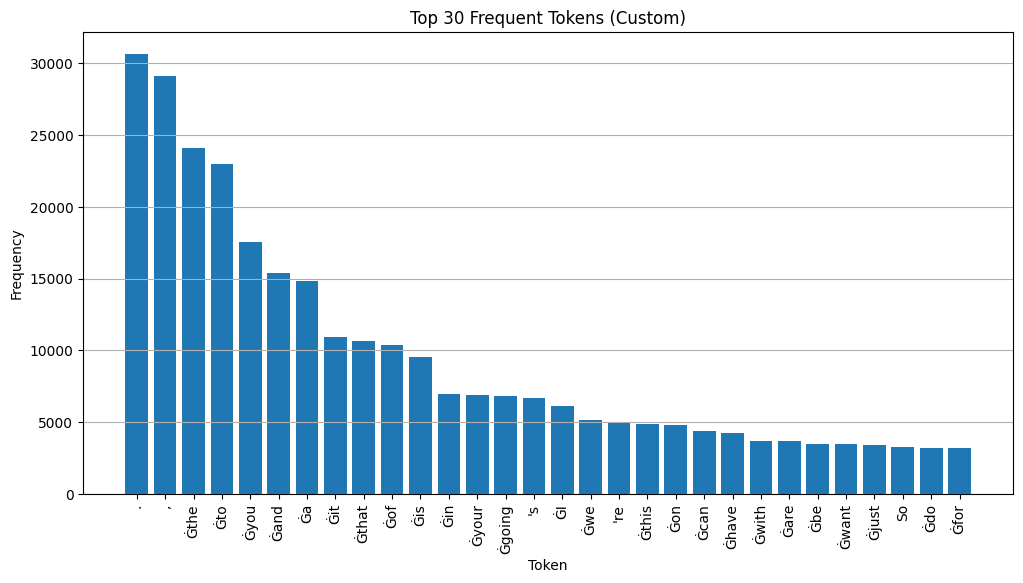

In [31]:
# Plot 2: Top 30 frequent tokens
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.bar(tokens, counts)
ax2.set_title("Top 30 Frequent Tokens (Custom)")
ax2.set_xticklabels(tokens, rotation=90)
ax2.set_xlabel("Token")
ax2.set_ylabel("Frequency")
ax2.grid(axis='y')


>Top 30 Frequent Tokens:

The bar chart shows that the most frequent tokens include punctuation marks (like “.” and “,”) and a number of Byte-Level BPE fragments prefixed by “Ġ”. A handful of sub-words such as “Ġthe”, “Ġto”, and “Ġand” dominate, but none of them seems overly surprising. Still if we had more time, the fact that punctuation ranks so highly suggests we could normalize or remove certain symbols if they’re not semantically useful and then retrain the tokenizer. Overall, we see a reasonably balanced spread across the top 30, which indicates our vocab_size isn’t being monopolized by a tiny set of tokens.

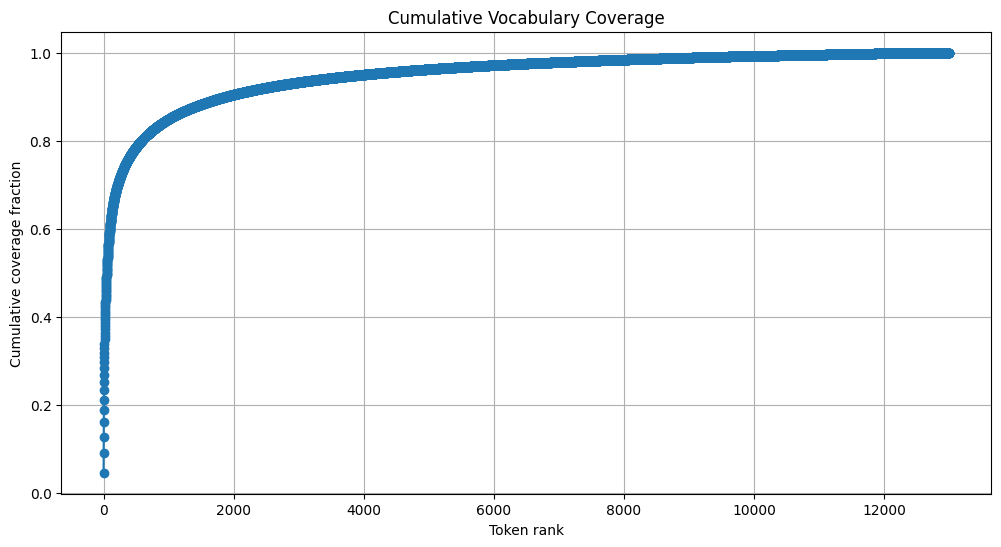

In [32]:
fig3, ax3 = plt.subplots(figsize=(12, 6))
ax3.plot(cum_coverage, marker='o')
ax3.set_title("Cumulative Vocabulary Coverage")
ax3.set_xlabel("Token rank")
ax3.set_ylabel("Cumulative coverage fraction")
ax3.grid(True)



>Cumulative Vocabulary Coverage:

The cumulative curve climbs very steeply at first over 80% coverage is reached within the top ~1,000 tokens and then flattens out, approaching 100% only after accounting for several thousand rare tokens. This confirms that the majority of our text uses a relatively small core vocabulary, and that setting vocab_size around 10–15 K would already capture most of the corpus. Our current size of ~50 K tokens provides extra headroom for rare words and sub-word combinations, but we could likely shrink it if we wanted to reduce model complexity.

#  B- Encode & Decode Example Comparison

In [13]:
# Cell 3: Encode & Decode Example Comparison
text = "This is a test sentence for comparing tokenizers for COM-304 demo ."

enc_base = base_tok(text)
dec_base = base_tok.decode(enc_base.input_ids, clean_up_tokenization_spaces=True)
enc_custom = custom_tok(text)
dec_custom = custom_tok.decode(enc_custom.input_ids, clean_up_tokenization_spaces=True)

print("Original:  ", text)
print("Base decode:", dec_base)
print("Custom decode:", dec_custom)
print("Base tokens:", base_tok.convert_ids_to_tokens(enc_base.input_ids))
print("Custom tokens:", custom_tok.convert_ids_to_tokens(enc_custom.input_ids))

Original:   This is a test sentence for comparing tokenizers for COM-304 demo .
Base decode: This is a test sentence for comparing tokenizers for COM-304 demo.
Custom decode: This Ġis Ġa Ġtest Ġsent ence Ġfor Ġcomp aring Ġto ken izers Ġfor ĠCO M - 30 4 Ġdemo Ġ.
Base tokens: ['This', 'Ġis', 'Ġa', 'Ġtest', 'Ġsentence', 'Ġfor', 'Ġcomparing', 'Ġtoken', 'izers', 'Ġfor', 'ĠCOM', '-', '304', 'Ġdemo', 'Ġ.']
Custom tokens: ['This', 'Ġis', 'Ġa', 'Ġtest', 'Ġsent', 'ence', 'Ġfor', 'Ġcomp', 'aring', 'Ġto', 'ken', 'izers', 'Ġfor', 'ĠCO', 'M', '-', '30', '4', 'Ġdemo', 'Ġ.']


>When we run the example through both tokenizers, GPT-2’s default vocabulary cleanly handles “sentence” and “COM-304” as whole units, whereas our custom tokenizer splits them into sub-words (“sent” + “ence”, “CO” + “M” + “30” + “4”). That’s because “COM-304” never appeared in our original, relatively small dataset, so with only 15 K tokens it didn’t learn those full words. We accept that trade-off our smaller vocab guarantees no out-of-vocabulary tokens at all, since every new string is broken into known pieces.

>If we had more time, we would either expand our training corpus to include such acronyms, modestly increase vocab_size to capture high-value tokens whole (like “COM-304”), or add targeted post-processing that merges frequent sub-word pairs back into full tokens. These tweaks would preserve the robustness of sub-word coverage while smoothing over any choppy reconstructions.

# C - Token Length Distribution Comparison

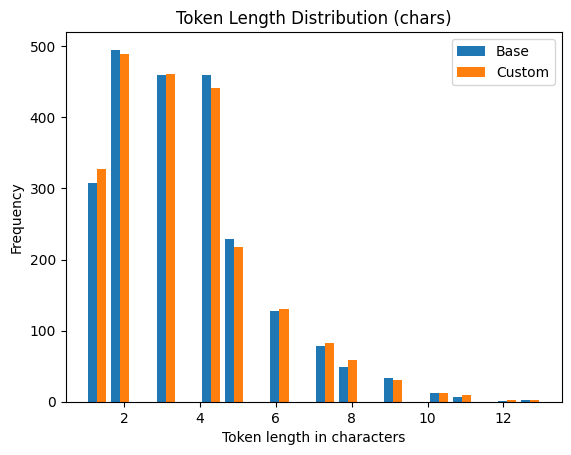

In [27]:
# Cell 4: Token Length Distribution Comparison
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib here as well for clarity

def token_length_distribution(tokenizer, texts):
    lengths = []
    for t in texts:

        toks = tokenizer(t).tokens()
        lengths.extend([len(tok.replace("Ġ","")) for tok in toks])
    return lengths


sample = eval_texts
base_lens = token_length_distribution(base_tok, sample)
custom_lens = token_length_distribution(custom_tok, sample)

plt.figure()
plt.hist([base_lens, custom_lens], bins=20, label=["Base", "Custom"])
plt.title("Token Length Distribution (chars)")
plt.xlabel("Token length in characters")
plt.ylabel("Frequency")
plt.legend()
plt.show()


>When we directly compare token-length histograms side-by-side for the baseline GPT-2 tokenizer (blue) and our custom tokenizer (orange), we see that both vocabularies heavily favor short sub-word units, with the vast majority of tokens falling between 2 and 4 characters.

>Yet our custom tokenizer exhibits a  nudge toward even shorter pieces: single-character tokens are more frequent, and the orange bars for lengths 1 and 2 slightly exceed the blue bars. This arises because our 15 K-token vocabulary cannot include every medium-length word or common substring, so it “falls back” more often to minimal building blocks. In contrast, GPT-2’s 50 K-token vocabulary can afford to include more three- and four-character tokens outright, reducing the need for aggressive splitting.

>Functionally, this means our custom vocabulary guarantees zero out-of-vocabulary terms every unseen word simply becomes a sequence of known fragments—but at the cost of increased fragmentation. To balance coverage with readability, we could modestly expand vocab_size or inject high-value multi-character tokens (for instance, frequent acronyms or domain-specific terms) into our training data so they emerge as single tokens in the custom vocab, smoothing the tail of this distribution while preserving robust coverage.